# Plotting Feature Space

> Visualizing low-dimensional feature spaces

In [ ]:
#| default_exp feature_space_plotting

Since the backbone (in charge of embedding in feature space) plays such an intergral role in similarity learning, it's natural that we'd want to examine it.
While it's usually too high-dimensional to plot directly, we could force it to be low-dimensional for the purpose of plotting.

In [ ]:
#| export
import numpy as np
from fastai.vision.all import *
import matplotlib.pyplot as plt

In [ ]:
#| export
def plot_dataset_embedding(dataset: Datasets, feature_extractor, num_samples_per_class=300, normalize_features=False, *args, **kwargs):
    COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    feature_extractor.eval()

    with torch.no_grad():
        for c, ss in dataset.by_target.items():
            color = COLORS[dataset.vocab.o2i[c] % len(COLORS)]
            samples = ss.random_sub_dsets(num_samples_per_class).load()[0]
            embeddings = feature_extractor(samples)
            if normalize_features:
                embeddings = torch.nn.functional.normalize(embeddings, dim=1)

            _plot_cluster(embeddings.cpu().numpy(), color, label=c, *args, **kwargs)

    plt.legend()

def _plot_cluster(points: ndarray, color, *args, **kwargs):
    assert points.ndim == 2 and points.shape[1] == 2
    plt.scatter(*points.transpose(), color=color, *args, **kwargs)

In order to properly classify using only 3 features, we should pick a relatively simple dataset. Let's use `MNIST`:

In [ ]:
from torch import nn

from fastai_datasets.all import *

from similarity_learning.utils import *
from similarity_learning.siamese import *
from similarity_learning.pair_matching import *

In [ ]:
mnist = MNIST()
mnist = mnist.by_target['0'] + mnist.by_target['1'] + mnist.by_target['2'] + mnist.by_target['3'] + mnist.by_target['4']

In [ ]:
learn = Learner(mnist.dls(), MLP(10, features_dim=2), metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.129603,0.101818,0.976455,00:19


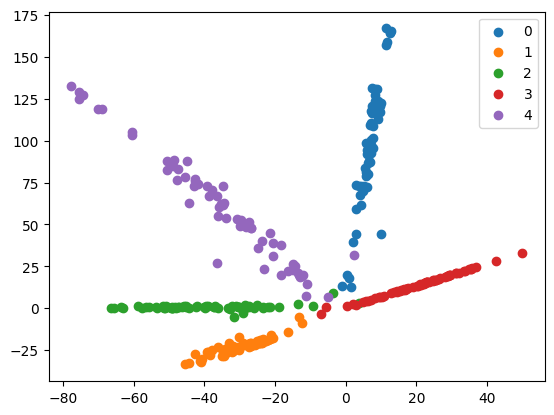

In [ ]:
plot_dataset_embedding(mnist, cut_model_by_name(learn.model, 'hidden_layers'))

Compare with training a `ThresholdSiamese` and extracting the backbone:

In [ ]:
learn = Learner(Pairs(mnist, 1).dls(), ThresholdSiamese(MLP(None, features_dim=2)), metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.323327,0.330968,0.948813,00:24


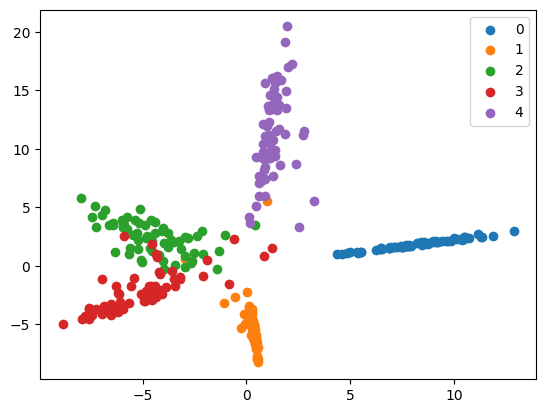

In [ ]:
plot_dataset_embedding(mnist, learn.model.distance.backbone)

And with training a backbone with `ContrastiveLoss`

In [ ]:
learn = Learner(Pairs(mnist, 1).dls(), DistanceSiamese(MLP(None, features_dim=2)), ContrastiveLoss())
learn.fit(1)

epoch,train_loss,valid_loss,time
0,0.096365,0.080131,00:24


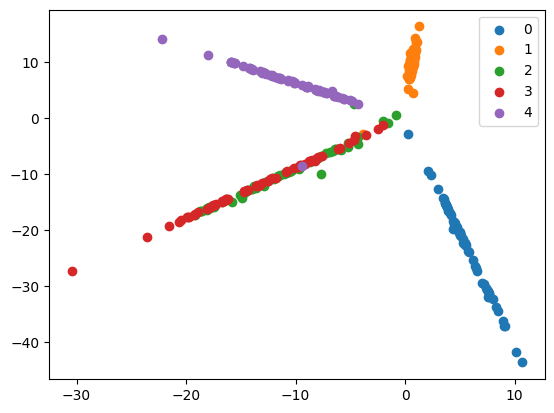

In [ ]:
plot_dataset_embedding(mnist, learn.model.backbone)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()